In [1]:
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# read names that have provided survey eye color data
columns = ['name', 'left', 'right', 'left_desc', 'right_desc']

# pgp eye color data from survey
surveyData = pd.read_csv("PGP-eyecolor.csv", names=columns, na_values=['nan', ''])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

In [3]:
# load numpy array of names and keep only the huID
pgpNames = np.load("names.npy")
for i in range(len(pgpNames)):
    pgpNames[i] = pgpNames[i][:8]

# load numpy array of tiled PGP data 
pgp = np.load("hiq-pgp.npy")

In [4]:
# lookup a name in the survey data and return a tuple of the eye colors
def getData(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            return (row['left'], row['right'])

In [5]:
# list of tuples for index and name with eye color data
namePairIndices = []

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
nameLeftEyeMap = {}
nameRightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i in range(len(pgpNames)):
    name = pgpNames[i]
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        eyeData = getData(name, surveyData)
        namePairIndices.append((i, name))
        nameLeftEyeMap[name] = eyeData[0]
        nameRightEyeMap[name] = eyeData[1]

# create lists containing the known eye color names and the unknown eye colors.
nameIndices = [nameIndex[0] for nameIndex in namePairIndices]
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [16]:
# convert dictionaries to lists 
leftEyeNameList = []
rightEyeNameList = []

for nameTuple in namePairIndices:
    leftEyeNameList.append(nameLeftEyeMap[nameTuple[1]])
    rightEyeNameList.append(nameRightEyeMap[nameTuple[1]])
    
for i in range(len(leftEyeNameList)): # classify only blue/not blue, so change all the colors above 12 to not blue
    if leftEyeNameList[i] > 12:
        leftEyeNameList[i] = 0 # not blue
    else:
        leftEyeNameList[i] = 1 # blue

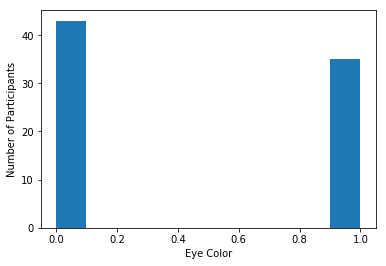

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(leftEyeNameList)
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color")
plt.show()

In [18]:
from sklearn import preprocessing
knownData = preprocessing.scale(knownData.astype('double')) # scale the data
knownData

array([[-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

[LibLinear]0.6875


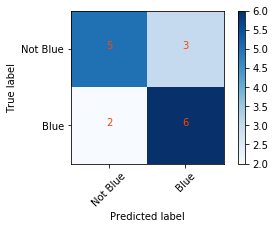

In [20]:
# train test split on the data
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                         C=.06, dual=False, verbose=1, max_iter=1500)
X_train, X_test, y_train, y_test = train_test_split(knownData, leftEyeNameList, 
                                                    test_size=.2, random_state=1)
svc_test.fit(X_train, y_train)
y_pred = svc_test.predict(X_test)
print accuracy_score(y_test, y_pred)

# create confusion matrix - code taken from Sarah's blood type prediction
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')

classes = ['Not Blue','Blue']

plt.grid('off')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color= "orangered")

plt.gcf().subplots_adjust(left=0.25, bottom = 0.35)
plt.savefig('Blue_Confusion.png',format='png',dpi=300)

In [13]:
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                         C=.06, dual=False, verbose=1, max_iter=5000)
cv_scores = cross_val_score(svc_test, knownData, leftEyeNameList, cv=20, scoring='accuracy')
print
print cv_scores.mean()
print cv_scores.std()
print "\n\n"

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
0.6925
0.175394396844





In [10]:
from sklearn.model_selection import LeaveOneOut

leftOut = LeaveOneOut()
leftEyeNameList = np.asarray(leftEyeNameList)
scores = []
counter = 0
for train_index, test_index in leftOut.split(knownData):
    X_train, X_test = knownData[train_index], knownData[test_index]
    y_train, y_test = leftEyeNameList[train_index], leftEyeNameList[test_index]
    svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                         C=.06, dual=False, verbose=1, max_iter=5000)
    svc_test.fit(X_train, y_train)
    y_pred = svc_test.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    print y_test, y_pred
    print " Iteration: " + str(counter)
    counter += 1
    
np.mean(np.asarray(scores))

[LibLinear][1] [0]
 Iteration: 0
[LibLinear][1] [0]
 Iteration: 1
[LibLinear][1] [0]
 Iteration: 2
[LibLinear][1] [1]
 Iteration: 3
[LibLinear][1] [0]
 Iteration: 4
[LibLinear][0] [0]
 Iteration: 5
[LibLinear][0] [1]
 Iteration: 6
[LibLinear][0] [0]
 Iteration: 7
[LibLinear][0] [1]
 Iteration: 8
[LibLinear][0] [0]
 Iteration: 9
[LibLinear][0] [0]
 Iteration: 10
[LibLinear][1] [1]
 Iteration: 11
[LibLinear][0] [0]
 Iteration: 12
[LibLinear][0] [0]
 Iteration: 13
[LibLinear][0] [0]
 Iteration: 14
[LibLinear][0] [0]
 Iteration: 15
[LibLinear][1] [0]
 Iteration: 16
[LibLinear][0] [0]
 Iteration: 17
[LibLinear][1] [0]
 Iteration: 18
[LibLinear][1] [1]
 Iteration: 19
[LibLinear][0] [0]
 Iteration: 20
[LibLinear][0] [0]
 Iteration: 21
[LibLinear][1] [1]
 Iteration: 22
[LibLinear][1] [1]
 Iteration: 23
[LibLinear][1] [0]
 Iteration: 24
[LibLinear][1] [0]
 Iteration: 25
[LibLinear][0] [0]
 Iteration: 26
[LibLinear][1] [1]
 Iteration: 27
[LibLinear][1] [0]
 Iteration: 28
[LibLinear][1] [1]
 Iter

0.71794871794871795

In [12]:
import collections
collections.Counter(scores)

Counter({0.0: 22, 1.0: 56})

In [21]:
from sklearn.externals import joblib
svc_test.fit(knownData, leftEyeNameList)
y_pred = svc_test.predict(knownData)
print accuracy_score(leftEyeNameList, y_pred)

[LibLinear]1.0


In [22]:
joblib.dump(svc_test, "svc.pkl")

['svc.pkl']

In [18]:
print len(leftEyeNameList)

78
